In [1]:
import numpy as np
import pandas as pd
df=pd.read_csv('data_final.csv')
X=df.loc[:, ['Temperature', 'Addion_time', 'Mode','Reaction_time']]
X = (X-X.min())/(X.max()-X.min())
y= df.loc[:, [ 'Mn', 'PDI','Skewness','Kurtosis']]

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=1104)
kmeans=KMeans(n_clusters=5,random_state=50).fit(X_train)
centers = np.array(kmeans.cluster_centers_)

/root/miniconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [3]:
data_index_new1=np.arange(0,453)
X_train.index=data_index_new1
y_train.index=data_index_new1

In [4]:
from sklearn.metrics import pairwise_distances_argmin_min
closest, _ = pairwise_distances_argmin_min(centers, X_train)

In [5]:
data_inital=pd.concat([X_train.iloc[closest,],y_train.iloc[closest,]],axis=1,join='outer')

In [6]:
X_train_init=data_inital.loc[:,['Temperature', 'Addion_time', 'Mode','Reaction_time']]
y_train_init=data_inital.loc[:,[ 'Mn', 'PDI','Skewness','Kurtosis']]

In [7]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils import shuffle
from modAL.disagreement import max_std_sampling
from modAL.models import ActiveLearner, CommitteeRegressor
from modAL.uncertainty import entropy_sampling
from xgboost import XGBRegressor

In [8]:
def list_by_models(X,y):
    sklearn_list = [Ridge(), Lasso(), LinearRegression(),XGBRegressor(),RandomForestRegressor(n_estimators =50),RandomForestRegressor(n_estimators =100),KNeighborsRegressor(n_neighbors=2, weights='distance')]
    learner_list=[]
    for regressor_emcm in sklearn_list:
        learner=ActiveLearner(estimator=regressor_emcm, query_strategy=max_std_sampling, X_training=X, y_training=y)
        learner_list.append(learner)
    print(len(X))
    return learner_list

In [9]:
from numpy.linalg import norm
def expected_model_change_maximization(regressor, learner_list, X_pool, n_instances=1):
    changes = []
    for x in X_pool:
        x = x.reshape(1, -1)
        change = 0
        x_norm = norm(x)
        y_hat = regressor.predict(x)[0]
        for learner in learner_list:
            y_p = learner.predict(x)[0]
            change += abs(y_hat - y_p) * x_norm
            #change += abs(y_hat - y_p)
        change /= len(learner_list)
        changes.append(change)
    changes=np.squeeze(changes)
    #print(changes)
    changes_sum=changes.sum(axis=1)
    #print(changes_sum)
    query_idx = changes_sum.argsort()[-n_instances:][::-1]
    return query_idx

In [10]:
X_train_beiyong=X_train
y_train_beiyong=y_train

In [11]:
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
# search_best_score_list=[]
# for j in range(1,150):
#     regressor=RandomForestRegressor(n_estimators=j,random_state=66)
#     regressor.fit(X_train_init, y_train_init)
#     test_score=regressor.score(X_test, y_test)
#     search_best_score_list.append(test_score)
# best_score_index=search_best_score_list.index(max(search_best_score_list))
# j_best=best_score_index+1
regressor=XGBRegressor(n_estimators = 20, 
                   learning_rate = 0.05, 
                   max_depth=5,
                   random_state=66)
regressor.fit(X_train_init, y_train_init)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20, n_jobs=None,
             num_parallel_tree=None, random_state=66, ...)

In [12]:
data_final=data_inital#Inital data_final
test_score_list=[]
mean_squared_error_list=[]
inital_y_predict=regressor.predict(X_test)
mean_squared_error_list.append(metrics.mean_squared_error(y_test,inital_y_predict))
print('inital mse',metrics.mean_squared_error(y_test,inital_y_predict))
for i in range(1,41):
    print(len(X_train))
    if i==1:
        learner_list=list_by_models(X=X_train_init,y=y_train_init)
    else:
        learner_list=list_by_models(X=X_train_relabel,y=y_train_relabel)
    re_idx=expected_model_change_maximization(regressor, learner_list, X_train.values, n_instances=1)
    data_relable=pd.concat([X_train.iloc[re_idx,],y_train.iloc[re_idx,]],axis=1,join='outer')
    X_train=X_train.drop(re_idx)
    y_train=y_train.drop(re_idx)
    X_train=X_train.reset_index(drop=True)
    y_train=y_train.reset_index(drop=True)
    #data_final=pd.concat([data_inital,data_relable],axis=0,join='outer')
    data_final=pd.concat([data_final,data_relable],axis=0,join='outer')#iteration to update data_final
    #print(data_final)
    X_train_relabel=data_final.loc[:,['Temperature', 'Addion_time', 'Mode','Reaction_time']]
    y_train_relabel=data_final.loc[:,[ 'Mn', 'PDI','Skewness','Kurtosis']]
    #search_best_score_list=[]
    search_min_mse_list=[]
    for j in range(1,50):
        regressor=XGBRegressor(n_estimators = j, 
                   learning_rate = 0.05, 
                   max_depth=5,
                   random_state=66)
        regressor.fit(X_train_relabel, y_train_relabel)
        #test_score=regressor.score(X_test, y_test)
        y_predict=regressor.predict(X_test)
        mse=metrics.mean_squared_error(y_test, y_predict)
        #search_best_score_list.append(test_score)
        search_min_mse_list.append(mse)
    #print( search_best_score_list)
    best_score_index=search_min_mse_list.index(min(search_min_mse_list))
    j_best=best_score_index+1
    regressor=XGBRegressor(n_estimators = j_best, 
                   learning_rate = 0.05, 
                   max_depth=5,
                   random_state=66)
    regressor.fit(X_train_relabel, y_train_relabel)
    print("Testing Score:%f" % regressor.score(X_test, y_test))
    test_score_list.append(regressor.score(X_test, y_test))
    y_predict=regressor.predict(X_test)
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
    mean_squared_error_list.append(metrics.mean_squared_error(y_test, y_predict))
    r_error_all=(metrics.mean_absolute_error(y_predict,y_test))/np.mean(np.array(y_test))
    print('Related Error',r_error_all)

inital mse 48.61469767939108
453
5
Testing Score:-3.762223
Mean Squared Error: 38.69360257837092
Related Error 0.6368515460500329
452
6
Testing Score:-3.604515
Mean Squared Error: 39.094010980586916
Related Error 0.6390448797540026
451
7
Testing Score:-0.749310
Mean Squared Error: 39.77565986481498
Related Error 0.5214546790141585
450
8
Testing Score:-1.845157
Mean Squared Error: 38.3889907832439
Related Error 0.5920148415572268
449
9
Testing Score:-1.701084
Mean Squared Error: 30.25826529097253
Related Error 0.5634315058803718
448
10
Testing Score:-1.184718
Mean Squared Error: 20.691491975577577
Related Error 0.4768112539309453
447
11
Testing Score:-0.364787
Mean Squared Error: 14.418129240705381
Related Error 0.39377463530425566
446
12
Testing Score:-0.382551
Mean Squared Error: 12.267760286459662
Related Error 0.38504436668928216
445
13
Testing Score:-0.354144
Mean Squared Error: 12.119718896773676
Related Error 0.378967885708946
444
14
Testing Score:0.073799
Mean Squared Error: 9.4

In [156]:
def ASD(list):
    sum_ASD=0
    for i in range(1,len(list)-1):
        ASD_i=abs(list[i+1]-2*list[i]+list[i-1])
        sum_ASD=sum_ASD+ASD_i
    ASD=sum_ASD/(len(list)-2)
    return ASD       

In [14]:
mean_ASD_CMMC=ASD(mean_squared_error_list)

In [112]:
mean_ASD_CMMC

1.4136868058055119

In [168]:
convergence_threshold = 0.5
loss_diffs = np.diff(mean_squared_error_list)
loss_diffs =np.abs(loss_diffs )
print(loss_diffs)

for i in range(0,40):
    if loss_diffs[i]<convergence_threshold and loss_diffs[i+1]<convergence_threshold and loss_diffs[i+2]<convergence_threshold:
        print(i)
        break
FTC_CMMC=i

[9.9210951  0.4004084  0.68164888 1.38666908 8.13072549 9.56677332
 6.27336273 2.15036895 0.14804139 2.63514251 0.27364148 0.20071698
 0.08798022 1.72468755 0.87903106 0.28089417 0.38458529 1.75672966
 0.19874936 0.04558322 1.73742582 0.13770075 0.32326438 0.15092365
 0.03414663 0.41755841 0.1341202  0.07829346 0.08365642 0.10997273
 0.34144242 0.30864867 0.20693119 0.07756301 0.02014053 0.10226646
 0.1133461  0.38649248 0.12943926 0.46549006]
10


In [16]:
import math
logMSE=[math.log(x)+1 for x in mean_squared_error_list]
logAUC_CMMC=np.sum(logMSE)
logAUC_CMMC

135.50627107418887

In [154]:
X_train_random=X_train_beiyong
y_train_random=y_train_beiyong

In [155]:
from sklearn import metrics
import random
import warnings
warnings.filterwarnings("ignore")
regressor=XGBRegressor(n_estimators = 20, 
                   learning_rate = 0.05, 
                   max_depth=5)
regressor.fit(X_train_init, y_train_init)
#data_final=data_inital#Inital data_final
random_test_score_list=[]
random_mean_squared_error_list=[]
inital_y_predict=regressor.predict(X_test)
random_mean_squared_error_list.append(metrics.mean_squared_error(y_test,inital_y_predict))
for i in range(1,41):
    #re_idx=random.randint(0, len(X_train_random)-1)
    re_idx=random.sample(range(0, len(X_train_random)-1), i)
    print(re_idx)
    data_relable=pd.concat([X_train_random.iloc[re_idx,],y_train_random.iloc[re_idx,]],axis=1,join='outer')
    #X_train_random=X_train_random.drop(re_idx)
    #y_train_random=y_train_random.drop(re_idx)
    #X_train_random=X_train_random.reset_index(drop=True)
    #y_train_random=y_train_random.reset_index(drop=True)
    #data_final=pd.concat([data_inital,data_relable],axis=0,join='outer')
    #data_final=pd.concat([data_final,data_relable],axis=0,join='outer')#iteration to update data_final
    data_final=pd.concat([data_inital,data_relable],axis=0,join='outer')
    #print(data_final)
    X_train_relabel=data_final.loc[:,['Temperature', 'Addion_time', 'Mode','Reaction_time']]
    y_train_relabel=data_final.loc[:,[ 'Mn', 'PDI','Skewness','Kurtosis']]
    #search_best_score_list=[]
    search_min_mse_list=[]
    for j in range(1,50):
        regressor=XGBRegressor(n_estimators = j, 
                   learning_rate = 0.05, 
                   max_depth=5)
        regressor.fit(X_train_relabel, y_train_relabel)
        #test_score=regressor.score(X_test, y_test)
        #search_best_score_list.append(test_score)
        y_predict=regressor.predict(X_test)
        mse=metrics.mean_squared_error(y_test, y_predict)
        search_min_mse_list.append(mse)   
    #print( search_best_score_list)
    #best_score_index=search_best_score_list.index(max(search_best_score_list))
    best_score_index=search_min_mse_list.index(min(search_min_mse_list))
    j_best=best_score_index+1
    regressor=XGBRegressor(n_estimators = j_best, 
                   learning_rate = 0.05, 
                   max_depth=5)
    regressor.fit(X_train_relabel, y_train_relabel)
    print("Testing Score:%f" % regressor.score(X_test, y_test))
    random_test_score_list.append(regressor.score(X_test, y_test))
    y_predict=regressor.predict(X_test)
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
    random_mean_squared_error_list.append(metrics.mean_squared_error(y_test, y_predict))

[94]
Testing Score:0.284324
Mean Squared Error: 38.57799570706609
[291, 260]
Testing Score:0.279887
Mean Squared Error: 39.97727834989312
[161, 198, 422]
Testing Score:0.334361
Mean Squared Error: 38.28423122496034
[90, 409, 354, 399]
Testing Score:0.175453
Mean Squared Error: 38.646864451908506
[212, 199, 55, 25, 54]
Testing Score:0.248393
Mean Squared Error: 34.661446834141024
[362, 256, 87, 203, 101, 199]
Testing Score:0.377042
Mean Squared Error: 37.186071189780854
[101, 293, 92, 47, 127, 253, 234]
Testing Score:0.443629
Mean Squared Error: 37.8838238714765
[339, 132, 450, 375, 423, 351, 194, 163]
Testing Score:0.499816
Mean Squared Error: 34.2965814372669
[7, 318, 34, 194, 165, 280, 90, 141, 130]
Testing Score:0.326837
Mean Squared Error: 25.191534787025784
[334, 50, 440, 190, 354, 108, 173, 16, 284, 378]
Testing Score:0.299528
Mean Squared Error: 24.69479143319058
[364, 337, 272, 32, 131, 172, 414, 41, 273, 171, 162]
Testing Score:0.474211
Mean Squared Error: 23.741227255126013
[

In [157]:
# diff1_random = np.diff(random_mean_squared_error_list)
# abs_diff1_random = np.abs(diff1_random)
# diff2_random = np.diff(abs_diff1_random)
# ASD_random = abs_diff1_random[1:] * np.abs(diff2_random)
# mean_ASD_random = np.mean(ASD_random)
mean_ASD_random=ASD(random_mean_squared_error_list)
mean_ASD_random

8.487477509596905

In [158]:
convergence_threshold = 0.5
loss_diffs_random = np.diff(random_mean_squared_error_list)
loss_diffs_random =np.abs(loss_diffs_random )
print(loss_diffs_random)

for i in range(0,38):
    if loss_diffs_random[i]<convergence_threshold and loss_diffs_random[i+1]<convergence_threshold and loss_diffs_random[i+2]<convergence_threshold:
        print(i)
        break

[10.03670197  1.39928264  1.69304712  0.36263323  3.98541762  2.52462436
  0.69775268  3.58724243  9.10504665  0.49674335  0.95356418 12.30431895
 16.40833605  2.32125318  4.50190889  0.26223927  8.34470452 14.25708044
  7.159784    8.29781008 13.18682744  5.16283075  8.86967658  6.40247789
  2.21571437  0.43400138  4.79278609  1.97620731  5.82350164  2.70710306
  3.40209824  2.88197659  1.43969085 11.25802073 12.61904566  3.2102319
  3.90643281  0.55362489  1.1832413   0.30069525]


In [159]:
logMSE_random=[math.log(x)+1 for x in random_mean_squared_error_list]
logAUC_random=np.sum(logMSE_random)
logAUC_random

151.08335806874692

In [80]:
X_train_qbc=X_train_beiyong
y_train_qbc=y_train_beiyong

In [81]:
from sklearn.metrics import pairwise_distances, pairwise_distances_argmin_min
def mse_uncertainty(regressor, Xtrain, ytrain, Xpool, n_instances=1):
    query_idx = []
    ypred = regressor.predict(Xtrain)
    se = (ytrain - ypred) ** 2
    distances = pairwise_distances(Xpool, Xtrain)
    uncertainty = np.sum(np.dot(1 / distances, se), axis=1) / np.sum(1 / distances, axis=1)
    for i in range(n_instances):
        current_idx = np.argmax(uncertainty)
        query_idx.append(current_idx)
        uncertainty[current_idx] = 0
    return query_idx

In [82]:
import warnings
warnings.filterwarnings("ignore")
data_final=data_inital#Inital data_final
regressor=XGBRegressor(n_estimators = 20, 
                   learning_rate = 0.05, 
                   max_depth=5,random_state=66)
regressor.fit(X_train_init, y_train_init)
qbc_test_score_list=[]
qbc_mean_squared_error_list=[]
inital_y_predict=regressor.predict(X_test)
qbc_mean_squared_error_list.append(metrics.mean_squared_error(y_test,inital_y_predict))
for i in range(1,41):
    print(len(X_train_qbc))
    if i==1:
        X=X_train_init
        y=y_train_init
    else:
        X=X_train_relabel
        y=y_train_relabel
    re_idx=mse_uncertainty(regressor, X, y, X_train_qbc.values, n_instances=1)
    data_relable=pd.concat([X_train_qbc.iloc[re_idx,],y_train_qbc.iloc[re_idx,]],axis=1,join='outer')
    X_train_qbc=X_train_qbc.drop(re_idx)
    y_train_qbc=y_train_qbc.drop(re_idx)
    X_train_qbc=X_train_qbc.reset_index(drop=True)
    y_train_qbc=y_train_qbc.reset_index(drop=True)
    #data_final=pd.concat([data_inital,data_relable],axis=0,join='outer')
    data_final=pd.concat([data_final,data_relable],axis=0,join='outer')#iteration to update data_final
    #print(data_final)
    X_train_relabel=data_final.loc[:,['Temperature', 'Addion_time', 'Mode','Reaction_time']]
    y_train_relabel=data_final.loc[:,[ 'Mn', 'PDI','Skewness','Kurtosis']]
    #search_best_score_list=[]
    search_min_mse_list=[]
    for j in range(1,50):
        regressor=XGBRegressor(n_estimators = j, 
                   learning_rate = 0.05, 
                   max_depth=5,random_state=66)
        regressor.fit(X_train_relabel, y_train_relabel)
        #test_score=regressor.score(X_test, y_test)
        y_predict=regressor.predict(X_test)
        mse=metrics.mean_squared_error(y_test, y_predict)
        #search_best_score_list.append(test_score)
        search_min_mse_list.append(mse)
    #print( search_best_score_list)
    best_score_index=search_min_mse_list.index(min(search_min_mse_list))
    j_best=best_score_index+1
    regressor=XGBRegressor(n_estimators = j_best, 
                   learning_rate = 0.05, 
                   max_depth=5,random_state=66)
    regressor.fit(X_train_relabel, y_train_relabel)
    print("Testing Score:%f" % regressor.score(X_test, y_test))
    qbc_test_score_list.append(regressor.score(X_test, y_test))
    y_predict=regressor.predict(X_test)
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
    qbc_mean_squared_error_list.append(metrics.mean_squared_error(y_test, y_predict))

453
Testing Score:0.163752
Mean Squared Error: 38.33096870262542
452
Testing Score:0.142702
Mean Squared Error: 38.07131585820454
451
Testing Score:0.170854
Mean Squared Error: 38.07939326347817
450
Testing Score:0.230933
Mean Squared Error: 37.95286368752968
449
Testing Score:0.221441
Mean Squared Error: 37.780478201224376
448
Testing Score:0.241029
Mean Squared Error: 35.09964200711851
447
Testing Score:0.251709
Mean Squared Error: 35.02642100412765
446
Testing Score:0.302102
Mean Squared Error: 33.15758823266722
445
Testing Score:0.367208
Mean Squared Error: 32.33140964454475
444
Testing Score:0.425291
Mean Squared Error: 32.24305816038733
443
Testing Score:0.439347
Mean Squared Error: 32.237645564475116
442
Testing Score:0.444816
Mean Squared Error: 32.255182373176964
441
Testing Score:0.462697
Mean Squared Error: 32.398827087665445
440
Testing Score:0.476673
Mean Squared Error: 32.46424757892767
439
Testing Score:0.493447
Mean Squared Error: 32.43027911199016
438
Testing Score:0.5

In [85]:
# diff1_qbc = np.diff(qbc_mean_squared_error_list)
# abs_diff1_qbc = np.abs(diff1_qbc)
# diff2_qbc = np.diff(abs_diff1_qbc)
# ASD_qbc = abs_diff1_qbc[1:] * np.abs(diff2_qbc)
# mean_ASD_qbc = np.mean(ASD_qbc)
mean_ASD_qbc=ASD(qbc_mean_squared_error_list)
mean_ASD_qbc

1.716046586606422

In [178]:
convergence_threshold = 0.5
loss_diffs_qbc = np.diff(qbc_mean_squared_error_list)
loss_diffs_qbc =np.abs(loss_diffs_qbc )
print(loss_diffs_qbc)

for i in range(0,39):
    if loss_diffs_qbc[i]<convergence_threshold and loss_diffs_qbc[i+1]<convergence_threshold and loss_diffs_qbc[i+2]<convergence_threshold:
        print(i)
        break
# For this special situation, if we dirctly use the FTC to calculate it, it returns 1. But it did not converge, and then MSE fluctuated significantly again.
# So we manually find the real convergence time, that is, step 9.
FTC_qbc=9

[1.02837290e+01 2.59652844e-01 8.07740527e-03 1.26529576e-01
 1.72385486e-01 2.68083619e+00 7.32210030e-02 1.86883277e+00
 8.26178588e-01 8.83514842e-02 5.41259591e-03 1.75368087e-02
 1.43644714e-01 6.54204913e-02 3.39684669e-02 3.96839263e-02
 4.29898057e+00 2.43185989e+00 3.35382664e+00 1.75878156e+00
 2.92580808e-01 2.16306198e-01 9.23651422e-01 8.74477718e-02
 1.38252854e-01 4.53175579e-01 2.27426148e-01 1.94846002e-01
 1.19232226e+01 9.04714025e-01 6.23078310e-02 1.01731455e-01
 5.94895532e-02 9.16831534e-01 1.39086137e-01 1.88726400e-01
 3.05222353e+00 4.82375333e-02 2.32114753e-02 2.51369638e-02]
1


In [87]:
logMSE_qbc = [math.log(x) + 1 for x in qbc_mean_squared_error_list]
logAUC_qbc = np.sum(logMSE_qbc)
logAUC_qbc

166.69128999253172

In [28]:
X_train_udi=X_train_beiyong
y_train_udi=y_train_beiyong

In [29]:
from sklearn.linear_model import LogisticRegression
def discretization_uncertainty(classifier, X_train, y_train, X_pool, bins, n_instances=1):
    _, bins_edges = np.histogram(y_train, bins)
    d_y_train = np.digitize(y_train, bins_edges)
    #print(d_y_train)
    d_y_train=np.sum(d_y_train, axis=1, keepdims=True)
    #print(d_y_train)
    classifier = LogisticRegression()
    learner = ActiveLearner(estimator=classifier, query_strategy=entropy_sampling,
        X_training=X_train, y_training=d_y_train)
    query_idx, _ = learner.query(X_pool, n_instances)
    return query_idx

In [30]:
import warnings
warnings.filterwarnings("ignore")
data_final=data_inital#Inital data_final
regressor=XGBRegressor(n_estimators = 20, 
                   learning_rate = 0.05, 
                   max_depth=5,random_state=66)
regressor.fit(X_train_init, y_train_init)
udi_test_score_list=[]
udi_mean_squared_error_list=[]
inital_y_predict=regressor.predict(X_test)
udi_mean_squared_error_list.append(metrics.mean_squared_error(y_test,inital_y_predict))
for i in range(1,41):
    print(len(X_train_udi))
    if i==1:
        X=X_train_init
        y=y_train_init
    else:
        X=X_train_relabel
        y=y_train_relabel
    re_idx=discretization_uncertainty(regressor,X, y, X_train_udi.values, bins=5,n_instances=1)
    data_relable=pd.concat([X_train_udi.iloc[re_idx,],y_train_udi.iloc[re_idx,]],axis=1,join='outer')
    X_train_udi=X_train_udi.drop(re_idx)
    y_train_udi=y_train_udi.drop(re_idx)
    X_train_udi=X_train_udi.reset_index(drop=True)
    y_train_udi=y_train_udi.reset_index(drop=True)
    #data_final=pd.concat([data_inital,data_relable],axis=0,join='outer')
    data_final=pd.concat([data_final,data_relable],axis=0,join='outer')#iteration to update data_final
    #print(data_final)
    X_train_relabel=data_final.loc[:,['Temperature', 'Addion_time', 'Mode','Reaction_time']]
    y_train_relabel=data_final.loc[:,[ 'Mn', 'PDI','Skewness','Kurtosis']]
    #search_best_score_list=[]
    search_min_mse_list=[]
    for j in range(1,50):
        regressor=XGBRegressor(n_estimators = j, 
                   learning_rate = 0.05, 
                   max_depth=5,random_state=66)
        regressor.fit(X_train_relabel, y_train_relabel)
        #test_score=regressor.score(X_test, y_test)
        y_predict=regressor.predict(X_test)
        mse=metrics.mean_squared_error(y_test, y_predict)
        #search_best_score_list.append(test_score)
        search_min_mse_list.append(mse)
    #print( search_best_score_list)
    best_score_index=search_min_mse_list.index(min(search_min_mse_list))
    j_best=best_score_index+1
    regressor=XGBRegressor(n_estimators = j_best, 
                   learning_rate = 0.05, 
                   max_depth=5,random_state=66)
    regressor.fit(X_train_relabel, y_train_relabel)
    print("Testing Score:%f" % regressor.score(X_test, y_test))
    udi_test_score_list.append(regressor.score(X_test, y_test))
    y_predict=regressor.predict(X_test)
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
    udi_mean_squared_error_list.append(metrics.mean_squared_error(y_test, y_predict))

453
Testing Score:0.152371
Mean Squared Error: 46.96012795792394
452
Testing Score:0.003504
Mean Squared Error: 32.60178772327205
451
Testing Score:-1.492111
Mean Squared Error: 43.34040042970447
450
Testing Score:-2.032956
Mean Squared Error: 45.014079242567824
449
Testing Score:-2.493988
Mean Squared Error: 47.45510883394311
448
Testing Score:-2.337214
Mean Squared Error: 46.645178825187664
447
Testing Score:-2.543198
Mean Squared Error: 47.45731103287066
446
Testing Score:-0.104352
Mean Squared Error: 15.856078077557001
445
Testing Score:-0.281538
Mean Squared Error: 17.346742528218513
444
Testing Score:-0.429742
Mean Squared Error: 17.783929752217478
443
Testing Score:-0.478131
Mean Squared Error: 15.311821304997146
442
Testing Score:-0.492641
Mean Squared Error: 14.524501235441797
441
Testing Score:-0.441961
Mean Squared Error: 14.156377647109178
440
Testing Score:-0.438329
Mean Squared Error: 13.430819682076274
439
Testing Score:-0.445216
Mean Squared Error: 12.960054501262857
43

In [31]:
# diff1_udi = np.diff(udi_mean_squared_error_list)
# abs_diff1_udi = np.abs(diff1_udi)
# diff2_udi = np.diff(abs_diff1_udi)
# ASD_udi = abs_diff1_udi[1:] * np.abs(diff2_udi)
# mean_ASD_udi = np.mean(ASD_udi)
mean_ASD_udi=ASD(udi_mean_squared_error_list)
mean_ASD_udi

3.490780459509802

In [170]:
convergence_threshold = 0.5
loss_diffs_udi = np.diff(udi_mean_squared_error_list)
loss_diffs_udi = np.abs(loss_diffs_udi)
print(loss_diffs_udi)

for i in range(0,39):
    if loss_diffs_udi[i] < convergence_threshold and loss_diffs_udi[i+1] < convergence_threshold and loss_diffs_udi[i+2] < convergence_threshold:
        print(i)
        break
FTC_udi=i

[ 1.65456972 14.35834023 10.73861271  1.67367881  2.44102959  0.80993001
  0.81213221 31.60123296  1.49066445  0.43718722  2.47210845  0.78732007
  0.36812359  0.72555797  0.47076518  0.03160347  0.59913766  0.42546795
  0.1140221   0.33276334  0.09871813  1.59515762  0.61929976  1.07060868
  1.20195505  0.29885147  0.22582108  0.3438196   0.08285106  0.1316911
  0.11756539  0.0801422   0.05454167  0.08087463  0.14374285  0.07120858
  0.4417716   0.1034986   0.48385906  0.09024756]
17


In [33]:
logMSE_udi = [math.log(x) + 1 for x in udi_mean_squared_error_list]
logAUC_udi = np.sum(logMSE_udi)
logAUC_udi 

157.67485115919501

In [34]:
X_train_ucl=X_train_beiyong
y_train_ucl=y_train_beiyong

In [35]:
from sklearn.metrics import silhouette_samples
def cluster_uncertainty(regressor, X_pool, n_clusters, n_instances=1):
    query_idx = []
    kmeans = KMeans(n_clusters)
    y_pool = pd.DataFrame(np.sum(regressor.predict(X_pool), axis=1, keepdims=True), columns=['y'])
    kmeans.fit(X_pool)
    y_pool['cluster'] = kmeans.labels_
    y_pool['silhouette'] = silhouette_samples(y_pool['y'].to_numpy().reshape(-1, 1), y_pool['cluster'])
    selected_clusters = y_pool.groupby('cluster').agg({'y': 'var'}).nlargest(n_instances, 'y').index.tolist()
    for cluster in selected_clusters:
        query_idx.append(y_pool[y_pool['cluster'] == cluster]['silhouette'].idxmin())
    return query_idx

In [36]:
import warnings
warnings.filterwarnings("ignore")
data_final=data_inital#Inital data_final
regressor=XGBRegressor(n_estimators = 20, 
                   learning_rate = 0.05, 
                   max_depth=5,random_state=66)
regressor.fit(X_train_init, y_train_init)
ucl_test_score_list=[]
ucl_mean_squared_error_list=[]
inital_y_predict=regressor.predict(X_test)
ucl_mean_squared_error_list.append(metrics.mean_squared_error(y_test,inital_y_predict))
for i in range(1,41):
    print(len(X_train_udi))
    if i==1:
        X=X_train_init
        y=y_train_init
    else:
        X=X_train_relabel
        y=y_train_relabel
    re_idx=cluster_uncertainty(regressor,X.values,n_clusters=2, n_instances=1)
    data_relable=pd.concat([X_train_ucl.iloc[re_idx,],y_train_ucl.iloc[re_idx,]],axis=1,join='outer')
    X_train_ucl=X_train_ucl.drop(re_idx)
    y_train_ucl=y_train_ucl.drop(re_idx)
    X_train_ucl=X_train_ucl.reset_index(drop=True)
    y_train_ucl=y_train_ucl.reset_index(drop=True)
    #data_final=pd.concat([data_inital,data_relable],axis=0,join='outer')
    data_final=pd.concat([data_final,data_relable],axis=0,join='outer')#iteration to update data_final
    #print(data_final)
    X_train_relabel=data_final.loc[:,['Temperature', 'Addion_time', 'Mode','Reaction_time']]
    y_train_relabel=data_final.loc[:,[ 'Mn', 'PDI','Skewness','Kurtosis']]
    #search_best_score_list=[]
    search_min_mse_list=[]
    for j in range(1,50):
        regressor=XGBRegressor(n_estimators = j, 
                   learning_rate = 0.05, 
                   max_depth=5,random_state=66)
        regressor.fit(X_train_relabel, y_train_relabel)
        #test_score=regressor.score(X_test, y_test)
        y_predict=regressor.predict(X_test)
        mse=metrics.mean_squared_error(y_test, y_predict)
        #search_best_score_list.append(test_score)
        search_min_mse_list.append(mse)
    #print( search_best_score_list)
    best_score_index=search_min_mse_list.index(min(search_min_mse_list))
    j_best=best_score_index+1
    regressor=XGBRegressor(n_estimators = j_best, 
                   learning_rate = 0.05, 
                   max_depth=5,random_state=66)
    regressor.fit(X_train_relabel, y_train_relabel)
    print("Testing Score:%f" % regressor.score(X_test, y_test))
    ucl_test_score_list.append(regressor.score(X_test, y_test))
    y_predict=regressor.predict(X_test)
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
    ucl_mean_squared_error_list.append(metrics.mean_squared_error(y_test, y_predict))

413
Testing Score:0.268687
Mean Squared Error: 38.713946525295825
413
Testing Score:0.341714
Mean Squared Error: 38.60173237491719
413
Testing Score:0.405623
Mean Squared Error: 38.02082534102135
413
Testing Score:0.439400
Mean Squared Error: 38.035634205028494
413
Testing Score:0.494424
Mean Squared Error: 37.9204140771983
413
Testing Score:0.482789
Mean Squared Error: 38.138689290942125
413
Testing Score:0.486327
Mean Squared Error: 40.057618242027765
413
Testing Score:0.487227
Mean Squared Error: 40.1471184334526
413
Testing Score:0.417926
Mean Squared Error: 45.21446457364172
413
Testing Score:0.441468
Mean Squared Error: 44.80417429016402
413
Testing Score:0.596372
Mean Squared Error: 17.015498660680453
413
Testing Score:0.598195
Mean Squared Error: 17.065724428029252
413
Testing Score:0.593315
Mean Squared Error: 15.851656549286776
413
Testing Score:0.584183
Mean Squared Error: 16.150354377125666
413
Testing Score:0.567419
Mean Squared Error: 16.28707622228763
413
Testing Score:0

In [37]:
# diff1_ucl = np.diff(ucl_mean_squared_error_list)
# abs_diff1_ucl = np.abs(diff1_ucl)
# diff2_ucl = np.diff(abs_diff1_ucl)
# ASD_ucl = abs_diff1_ucl[1:] * np.abs(diff2_ucl)
# mean_ASD_ucl = np.mean(ASD_ucl)
mean_ASD_ucl=ASD(ucl_mean_squared_error_list)
mean_ASD_ucl

2.6639622857531413

In [171]:
convergence_threshold = 0.5
loss_diffs_ucl = np.diff(ucl_mean_squared_error_list)
loss_diffs_ucl = np.abs(loss_diffs_ucl)
print(loss_diffs_ucl)

for i in range(0,39):
    if loss_diffs_ucl[i] < convergence_threshold and loss_diffs_ucl[i+1] < convergence_threshold and loss_diffs_ucl[i+2] < convergence_threshold:
        print(i)
        break
FTC_ucl=i

[9.90075115e+00 1.12214150e-01 5.80907034e-01 1.48088640e-02
 1.15220128e-01 2.18275214e-01 1.91892895e+00 8.95001914e-02
 5.06734614e+00 4.10290283e-01 2.77886756e+01 5.02257673e-02
 1.21406788e+00 2.98697828e-01 1.36721845e-01 4.75605672e+00
 1.36548519e-01 3.34466708e-01 1.40918783e+00 4.09730621e-02
 1.69079828e-01 2.61512108e-01 3.37640036e-01 1.17418344e+00
 1.08110476e-01 2.84400292e-02 1.53327183e-01 9.96626293e-02
 7.50786700e-01 7.38731444e-02 2.44385853e-01 2.01209943e-01
 1.16313484e+00 1.33765508e-01 8.23374469e-02 1.92648780e-02
 2.87988723e-02 3.24418790e-01 4.64067500e-02 4.26498419e-02]
3


In [39]:
logMSE_ucl = [math.log(x) + 1 for x in ucl_mean_squared_error_list]
logAUC_ucl = np.sum(logMSE_ucl)
logAUC_ucl

153.1030714948897

In [179]:
method=['CMMC','Random','UMSE','Udi',"Ucl"]
logAUC=[logAUC_CMMC,logAUC_random,logAUC_qbc,logAUC_udi ,logAUC_ucl]
ASD=[mean_ASD_CMMC,mean_ASD_random,mean_ASD_qbc,mean_ASD_udi,mean_ASD_ucl]
FTC=[FTC_CMMC,40,FTC_qbc,FTC_udi,FTC_ucl]

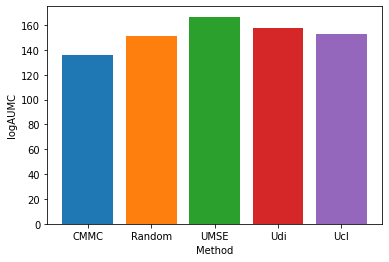

In [180]:
import matplotlib.pyplot as plt
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
plt.bar(method, logAUC,color=colors)
#plt.title('logAUC Comparison')
plt.xlabel('Method')
plt.ylabel('logAUMC')
plt.show()

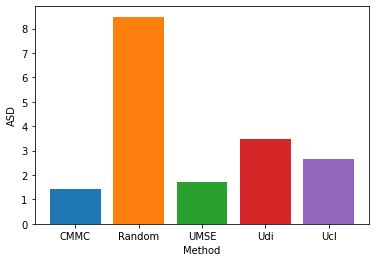

In [181]:
import matplotlib.pyplot as plt
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
plt.bar(method, ASD,color=colors)
#plt.title('ASD Comparison')
plt.xlabel('Method')
plt.ylabel('ASD')
plt.show()

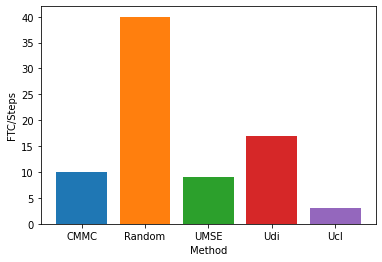

In [182]:
import matplotlib.pyplot as plt
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
plt.bar(method, FTC,color=colors)
#plt.title('FTC Comparison')
plt.xlabel('Method')
plt.ylabel('FTC/Steps')
plt.show()

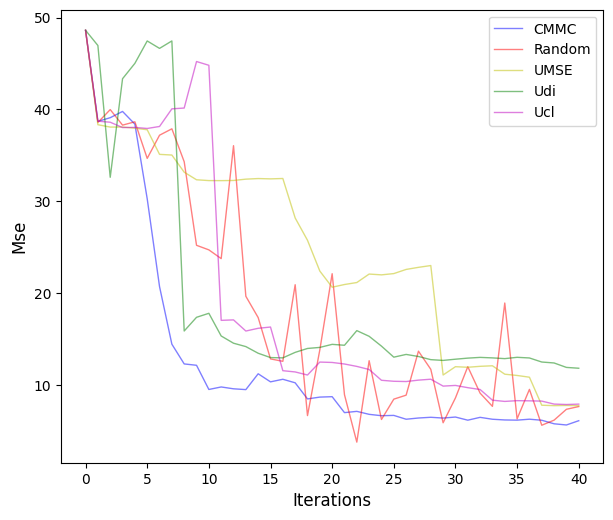

In [183]:
import matplotlib.pyplot as plt
number=np.arange(0,41)
fig, ax = plt.subplots(figsize=(7,6), dpi=100)
plt.plot(number, mean_squared_error_list, 'b-', alpha=0.5, linewidth=1, label='CMMC')
plt.plot(number, random_mean_squared_error_list, 'r-', alpha=0.5, linewidth=1, label='Random')
plt.plot(number, qbc_mean_squared_error_list, 'y-', alpha=0.5, linewidth=1, label='UMSE')
plt.plot(number, udi_mean_squared_error_list, 'g-', alpha=0.5, linewidth=1, label='Udi')
plt.plot(number, ucl_mean_squared_error_list, 'm-', alpha=0.5, linewidth=1, label='Ucl')
plt.legend()  #显示上面的label
plt.xlabel('Iterations', fontsize=12) #x_label
plt.ylabel('Mse',fontsize=12)#y_label

 
#plt.ylim(-1,1)#仅设置y轴坐标范围
plt.show()

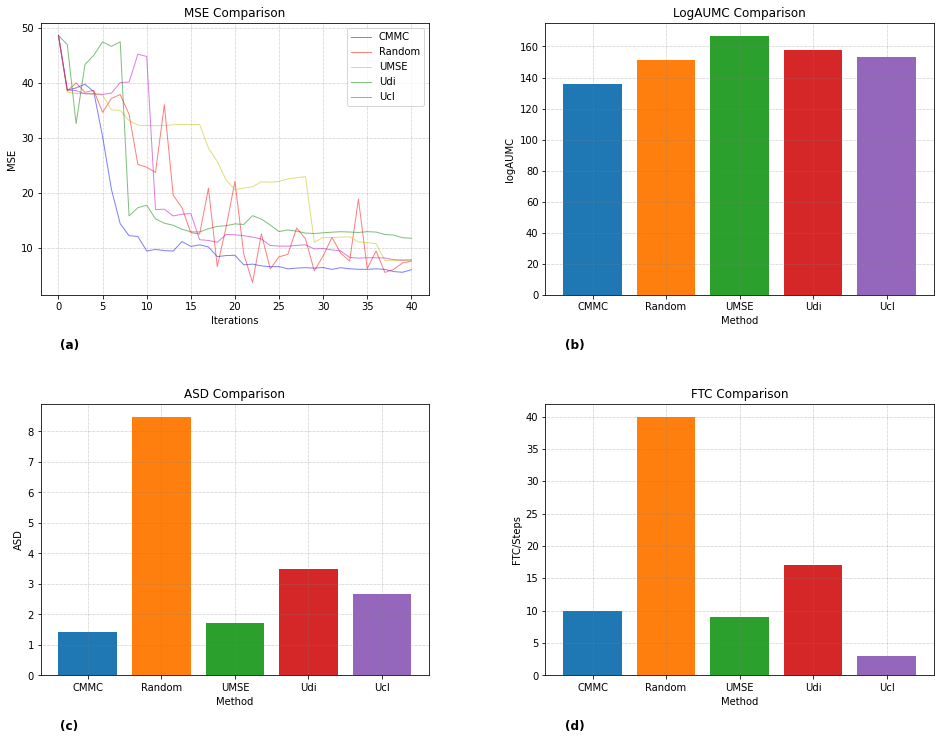

In [184]:
%matplotlib inline
import matplotlib.pyplot as plt

# 创建画布，设置子图大小和间距
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 2, hspace=0.4, wspace=0.3)

# 第1个子图
ax1 = fig.add_subplot(gs[0, 0])
number=np.arange(0,41)
ax1.plot(number, mean_squared_error_list, 'b-', alpha=0.5, linewidth=1, label='CMMC')
ax1.plot(number, random_mean_squared_error_list, 'r-', alpha=0.5, linewidth=1, label='Random')
ax1.plot(number, qbc_mean_squared_error_list, 'y-', alpha=0.5, linewidth=1, label='UMSE')
ax1.plot(number, udi_mean_squared_error_list, 'g-', alpha=0.5, linewidth=1, label='Udi')
ax1.plot(number, ucl_mean_squared_error_list, 'm-', alpha=0.5, linewidth=1, label='Ucl')
ax1.legend()  #显示上面的label
ax1.set_xlabel('Iterations') #x_label
ax1.set_ylabel('MSE')#y_label
ax1.set_title('MSE Comparison')
ax1.text(0.05, -0.2, "(a)", transform=ax1.transAxes, fontweight="bold", fontsize=12)

# 第2个子图
ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(method, logAUC, color=colors)
ax2.set_xlabel('Method')
ax2.set_ylabel('logAUMC')
ax2.set_title('LogAUMC Comparison')
ax2.text(0.05, -0.2, "(b)", transform=ax2.transAxes, fontweight="bold", fontsize=12)

# 第3个子图
ax3 = fig.add_subplot(gs[1, 0])
ax3.bar(method, ASD, color=colors)
ax3.set_xlabel('Method')
ax3.set_ylabel('ASD')
ax3.set_title('ASD Comparison')
ax3.text(0.05, -0.2, "(c)", transform=ax3.transAxes, fontweight="bold", fontsize=12)

# 第4个子图
ax4 = fig.add_subplot(gs[1, 1])
ax4.bar(method, FTC, color=colors)
ax4.set_xlabel('Method')
ax4.set_ylabel('FTC/Steps')
ax4.set_title('FTC Comparison')
ax4.text(0.05, -0.2, "(d)", transform=ax4.transAxes, fontweight="bold", fontsize=12)



# 设置所有子图的网格线
for ax in [ax1, ax2, ax3, ax4]:
    ax.grid(color='gray', linestyle=':', linewidth=0.5)

# 显示所有子图
plt.show()


In [166]:
mean_squared_error_list[0:45:5]

[48.61469767939108,
 30.25826529097253,
 9.484576386780533,
 10.31517716537537,
 8.699088970788722,
 6.659322501567804,
 6.480494061402788,
 6.143065575675186,
 6.081544256927611]

In [167]:
random_mean_squared_error_list[0:45:5]

[48.61469767939108,
 34.661446834141024,
 24.69479143319058,
 12.814048096228735,
 22.09702699455992,
 8.430281852012406,
 8.56446343028827,
 6.283869293554378,
 7.62522982554506]

In [109]:
qbc_mean_squared_error_list[0:45:5]

[48.61469767939108,
 37.780478201224376,
 32.24305816038733,
 32.43027911199016,
 20.62651437275308,
 22.109857882863224,
 11.966797058364048,
 11.00979256498611,
 7.718679613580922]

In [110]:
udi_mean_squared_error_list[0:45:5]

[48.61469767939108,
 47.45510883394311,
 17.783929752217478,
 12.960054501262857,
 14.39984208297916,
 13.004418076175138,
 12.782468914511819,
 12.98850304578431,
 11.797917649788477]

In [111]:
ucl_mean_squared_error_list[0:45:5]

[48.61469767939108,
 37.9204140771983,
 44.80417429016402,
 16.28707622228763,
 12.42821904755086,
 10.37769315724301,
 9.925329384544222,
 8.265170685674649,
 7.888931237109563]

In [51]:
X_train_L1=X_train_beiyong
y_train_L1=y_train_beiyong

In [52]:
data_final=data_inital
regressor=Lasso(alpha=0.1,random_state=66)
regressor.fit(X_train_init, y_train_init)
L1_test_score_list=[]
L1_mean_squared_error_list=[]
L1_inital_y_predict=regressor.predict(X_test)
L1_mean_squared_error_list.append(metrics.mean_squared_error(y_test,inital_y_predict))
print('inital mse',metrics.mean_squared_error(y_test,inital_y_predict))
for i in range(1,41):
    print(len(X_train_L1))
    if i==1:
        learner_list=list_by_models(X=X_train_init,y=y_train_init)
    else:
        learner_list=list_by_models(X=X_train_relabel,y=y_train_relabel)
    re_idx=expected_model_change_maximization(regressor, learner_list, X_train_L1.values, n_instances=1)
    data_relable=pd.concat([X_train_L1.iloc[re_idx,],y_train_L1.iloc[re_idx,]],axis=1,join='outer')
    X_train_L1=X_train_L1.drop(re_idx)
    y_train_L1=y_train_L1.drop(re_idx)
    X_train_L1=X_train_L1.reset_index(drop=True)
    y_train_L1=y_train_L1.reset_index(drop=True)
    #data_final=pd.concat([data_inital,data_relable],axis=0,join='outer')
    data_final=pd.concat([data_final,data_relable],axis=0,join='outer')#iteration to update data_final
    #print(data_final)
    X_train_relabel=data_final.loc[:,['Temperature', 'Addion_time', 'Mode','Reaction_time']]
    y_train_relabel=data_final.loc[:,[ 'Mn', 'PDI','Skewness','Kurtosis']]
    search_min_mse_list=[]
    for j in range(1,20):
        regressor=Lasso(alpha=j/10,random_state=66)
        regressor.fit(X_train_relabel, y_train_relabel)
        #test_score=regressor.score(X_test, y_test)
        y_predict=regressor.predict(X_test)
        mse=metrics.mean_squared_error(y_test, y_predict)
        #search_best_score_list.append(test_score)
        search_min_mse_list.append(mse)
    #print( search_best_score_list)
    best_score_index=search_min_mse_list.index(min(search_min_mse_list))
    j_best=(best_score_index+1)/10
    regressor=Lasso(alpha=j_best,random_state=66)
    regressor.fit(X_train_relabel, y_train_relabel)
    print("Testing Score:%f" % regressor.score(X_test, y_test))
    L1_test_score_list.append(regressor.score(X_test, y_test))
    y_predict=regressor.predict(X_test)
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
    L1_mean_squared_error_list.append(metrics.mean_squared_error(y_test, y_predict))

inital mse 48.61469767939108
453
5
Testing Score:0.428706
Mean Squared Error: 24.14625580882209
452
6
Testing Score:0.035975
Mean Squared Error: 22.729445631201756
451
7
Testing Score:0.095765
Mean Squared Error: 23.020913036847208
450
8
Testing Score:-0.045407
Mean Squared Error: 24.97835539871901
449
9
Testing Score:-0.241207
Mean Squared Error: 28.334073896113885
448
10
Testing Score:-0.083783
Mean Squared Error: 28.020256598974942
447
11
Testing Score:-0.227018
Mean Squared Error: 29.775780501307608
446
12
Testing Score:-0.288124
Mean Squared Error: 31.517723876338792
445
13
Testing Score:-0.389965
Mean Squared Error: 32.586222921725614
444
14
Testing Score:-0.176757
Mean Squared Error: 29.00904582837372
443
15
Testing Score:0.315114
Mean Squared Error: 25.840740131025782
442
16
Testing Score:0.439624
Mean Squared Error: 24.565453653190577
441
17
Testing Score:0.452003
Mean Squared Error: 24.235233209457096
440
18
Testing Score:0.573598
Mean Squared Error: 23.4619089318443
439
19
T

In [53]:
def ASD(list):
    sum_ASD=0
    for i in range(1,len(list)-1):
        ASD_i=abs(list[i+1]-2*list[i]+list[i-1])
        sum_ASD=sum_ASD+ASD_i
    ASD=sum_ASD/(len(list)-2)
    return ASD 

mean_ASD_L1=ASD(L1_mean_squared_error_list)
print('mean_ASD_L1 is',mean_ASD_L1)

convergence_threshold = 0.5
loss_diffs_L1 = np.diff(L1_mean_squared_error_list)
loss_diffs_L1 = np.abs(loss_diffs_L1)

for i in range(0,39):
    if loss_diffs_L1[i]<convergence_threshold and loss_diffs_L1[i+1]<convergence_threshold and loss_diffs_L1[i+2]<convergence_threshold:
        print(i)
        break
        
FTC_L1=i

logMSE_L1=[math.log(x)+1 for x in L1_mean_squared_error_list]
logAUC_L1=np.sum(logMSE_L1)
print('logAUC_L1 is ',logAUC_L1)

mean_ASD_L1 is 1.769723410819132
28
logAUC_L1 is  171.75941404083315


In [54]:
X_train_L2=X_train_beiyong
y_train_L2=y_train_beiyong

In [55]:
data_final=data_inital
regressor=Ridge(alpha=0.1,random_state=66)
regressor.fit(X_train_init, y_train_init)
L2_test_score_list=[]
L2_mean_squared_error_list=[]
L2_inital_y_predict=regressor.predict(X_test)
L2_mean_squared_error_list.append(metrics.mean_squared_error(y_test,inital_y_predict))
print('inital mse',metrics.mean_squared_error(y_test,inital_y_predict))
for i in range(1,41):
    print(len(X_train_L2))
    if i==1:
        learner_list=list_by_models(X=X_train_init,y=y_train_init)
    else:
        learner_list=list_by_models(X=X_train_relabel,y=y_train_relabel)
    re_idx=expected_model_change_maximization(regressor, learner_list, X_train_L2.values, n_instances=1)
    data_relable=pd.concat([X_train_L2.iloc[re_idx,],y_train_L2.iloc[re_idx,]],axis=1,join='outer')
    X_train_L2=X_train_L2.drop(re_idx)
    y_train_L2=y_train_L2.drop(re_idx)
    X_train_L2=X_train_L2.reset_index(drop=True)
    y_train_L2=y_train_L2.reset_index(drop=True)
    #data_final=pd.concat([data_inital,data_relable],axis=0,join='outer')
    data_final=pd.concat([data_final,data_relable],axis=0,join='outer')#iteration to update data_final
    #print(data_final)
    X_train_relabel=data_final.loc[:,['Temperature', 'Addion_time', 'Mode','Reaction_time']]
    y_train_relabel=data_final.loc[:,[ 'Mn', 'PDI','Skewness','Kurtosis']]
    search_min_mse_list=[]
    for j in range(1,20):
        regressor=Ridge(alpha=j/10,random_state=66)
        regressor.fit(X_train_relabel, y_train_relabel)
        #test_score=regressor.score(X_test, y_test)
        y_predict=regressor.predict(X_test)
        mse=metrics.mean_squared_error(y_test, y_predict)
        #search_best_score_list.append(test_score)
        search_min_mse_list.append(mse)
    #print( search_best_score_list)
    best_score_index=search_min_mse_list.index(min(search_min_mse_list))
    j_best=(best_score_index+1)/10
    regressor=Ridge(alpha=j_best,random_state=66)
    regressor.fit(X_train_relabel, y_train_relabel)
    print("Testing Score:%f" % regressor.score(X_test, y_test))
    L2_test_score_list.append(regressor.score(X_test, y_test))
    y_predict=regressor.predict(X_test)
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
    L2_mean_squared_error_list.append(metrics.mean_squared_error(y_test, y_predict))

inital mse 48.61469767939108
453
5
Testing Score:0.577712
Mean Squared Error: 29.605579013295657
452
6
Testing Score:0.609651
Mean Squared Error: 24.148984133690103
451
7
Testing Score:0.600402
Mean Squared Error: 23.92346065512466
450
8
Testing Score:0.643513
Mean Squared Error: 20.377311634730283
449
9
Testing Score:0.619233
Mean Squared Error: 22.15563229850994
448
10
Testing Score:0.608858
Mean Squared Error: 23.208347879398865
447
11
Testing Score:0.643483
Mean Squared Error: 23.790837164073814
446
12
Testing Score:0.688381
Mean Squared Error: 20.5944665260264
445
13
Testing Score:0.674160
Mean Squared Error: 21.864864824319735
444
14
Testing Score:0.667505
Mean Squared Error: 22.493366107796692
443
15
Testing Score:0.674779
Mean Squared Error: 21.86230448292716
442
16
Testing Score:0.676758
Mean Squared Error: 21.65141798271429
441
17
Testing Score:0.667138
Mean Squared Error: 22.3481200858773
440
18
Testing Score:0.666901
Mean Squared Error: 22.1968259007748
439
19
Testing Score

In [56]:
# diff1_L2 = np.diff(L2_mean_squared_error_list)
# abs_diff1_L2 = np.abs(diff1_L2)
# diff2_L2 = np.diff(abs_diff1_L2)
# ASD_L2 = abs_diff1_L2[1:] * np.abs(diff2_L2)
# mean_ASD_L2 = np.mean(ASD_L2)
mean_ASD_L2=ASD(L2_mean_squared_error_list)
print('mean_ASD_L2 is',mean_ASD_L2)

convergence_threshold = 0.5
loss_diffs_L2 = np.diff(L2_mean_squared_error_list)
loss_diffs_L2 = np.abs(loss_diffs_L2)

for i in range(0,39):
    if loss_diffs_L2[i]<convergence_threshold and loss_diffs_L2[i+1]<convergence_threshold and loss_diffs_L2[i+2]<convergence_threshold:
        print(i)
        break

FTC_L2=i
logMSE_L2=[math.log(x)+1 for x in L2_mean_squared_error_list]
logAUC_L2=np.sum(logMSE_L2)
print('logAUC_L2 is ',logAUC_L2)

mean_ASD_L2 is 1.7705574035753109
31
logAUC_L2 is  167.91865599304197


In [57]:
X_train_KN=X_train_beiyong
y_train_KN=y_train_beiyong

In [58]:
data_final=data_inital
regressor=KNeighborsRegressor(n_neighbors=2, weights='distance')
regressor.fit(X_train_init, y_train_init)
KN_test_score_list=[]
KN_mean_squared_error_list=[]
KN_inital_y_predict=regressor.predict(X_test)
KN_mean_squared_error_list.append(metrics.mean_squared_error(y_test,inital_y_predict))
print('inital mse',metrics.mean_squared_error(y_test,inital_y_predict))
for i in range(1,41):
    print(len(X_train_KN))
    if i==1:
        learner_list=list_by_models(X=X_train_init,y=y_train_init)
    else:
        learner_list=list_by_models(X=X_train_relabel,y=y_train_relabel)
    re_idx=expected_model_change_maximization(regressor, learner_list, X_train_KN.values, n_instances=1)
    data_relable=pd.concat([X_train_KN.iloc[re_idx,],y_train_KN.iloc[re_idx,]],axis=1,join='outer')
    X_train_KN=X_train_KN.drop(re_idx)
    y_train_KN=y_train_KN.drop(re_idx)
    X_train_KN=X_train_KN.reset_index(drop=True)
    y_train_KN=y_train_KN.reset_index(drop=True)
    #data_final=pd.concat([data_inital,data_relable],axis=0,join='outer')
    data_final=pd.concat([data_final,data_relable],axis=0,join='outer')#iteration to update data_final
    #print(data_final)
    X_train_relabel=data_final.loc[:,['Temperature', 'Addion_time', 'Mode','Reaction_time']]
    y_train_relabel=data_final.loc[:,[ 'Mn', 'PDI','Skewness','Kurtosis']]
    search_min_mse_list=[]
    for j in range(1,5):
        regressor=KNeighborsRegressor(n_neighbors=j, weights='distance')
        regressor.fit(X_train_relabel, y_train_relabel)
        #test_score=regressor.score(X_test, y_test)
        y_predict=regressor.predict(X_test)
        mse=metrics.mean_squared_error(y_test, y_predict)
        #search_best_score_list.append(test_score)
        search_min_mse_list.append(mse)
    #print( search_best_score_list)
    best_score_index=search_min_mse_list.index(min(search_min_mse_list))
    j_best=best_score_index+1
    regressor=KNeighborsRegressor(n_neighbors=j_best, weights='distance')
    regressor.fit(X_train_relabel, y_train_relabel)
    print("Testing Score:%f" % regressor.score(X_test, y_test))
    KN_test_score_list.append(regressor.score(X_test, y_test))
    y_predict=regressor.predict(X_test)
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
    KN_mean_squared_error_list.append(metrics.mean_squared_error(y_test, y_predict))

inital mse 48.61469767939108
453
5
Testing Score:0.357890
Mean Squared Error: 29.36543020542266
452
6
Testing Score:0.301620
Mean Squared Error: 28.14458521242892
451
7
Testing Score:0.417008
Mean Squared Error: 26.402350909202855
450
8
Testing Score:0.457139
Mean Squared Error: 22.161806855393092
449
9
Testing Score:0.444466
Mean Squared Error: 19.73316879927823
448
10
Testing Score:0.520515
Mean Squared Error: 17.05788328735239
447
11
Testing Score:0.521786
Mean Squared Error: 17.52829986106762
446
12
Testing Score:0.492366
Mean Squared Error: 18.852818850262864
445
13
Testing Score:0.529650
Mean Squared Error: 14.499280491982201
444
14
Testing Score:0.523302
Mean Squared Error: 14.931042707502865
443
15
Testing Score:0.512084
Mean Squared Error: 19.132907990740215
442
16
Testing Score:0.528050
Mean Squared Error: 17.570311482595255
441
17
Testing Score:0.533340
Mean Squared Error: 17.46215190952759
440
18
Testing Score:0.610027
Mean Squared Error: 16.053301400748666
439
19
Testing S

In [59]:
# diff1_KN = np.diff(KN_mean_squared_error_list)
# abs_diff1_KN = np.abs(diff1_KN)
# diff2_KN = np.diff(abs_diff1_KN)
# ASD_KN = abs_diff1_KN[1:] * np.abs(diff2_KN)
# mean_ASD_KN = np.mean(ASD_KN)
mean_ASD_KN =ASD(KN_mean_squared_error_list)
print('mean_ASD_KN is',mean_ASD_KN)

convergence_threshold = 0.5
loss_diffs_KN = np.diff(KN_mean_squared_error_list)
loss_diffs_KN = np.abs(loss_diffs_KN)

for i in range(0,39):
    if loss_diffs_KN[i]<convergence_threshold and loss_diffs_KN[i+1]<convergence_threshold and loss_diffs_KN[i+2]<convergence_threshold:
        print(i)
        break
FTC_KN=i
logMSE_KN=[math.log(x)+1 for x in KN_mean_squared_error_list]
logAUC_KN=np.sum(logMSE_KN)
print('logAUC_KN is ',logAUC_KN)

mean_ASD_KN is 1.9804082033508832
14
logAUC_KN is  153.61589276846334


In [66]:
X_train_xgb=X_train_beiyong
y_train_xgb=y_train_beiyong

In [67]:
data_final=data_inital
regressor=RandomForestRegressor(random_state=66)
regressor.fit(X_train_init, y_train_init)
xgb_test_score_list=[]
xgb_mean_squared_error_list=[]
xgb_inital_y_predict=regressor.predict(X_test)
xgb_mean_squared_error_list.append(metrics.mean_squared_error(y_test,inital_y_predict))
print('inital mse',metrics.mean_squared_error(y_test,inital_y_predict))
for i in range(1,41):
    #print(len(X_train_KN))
    if i==1:
        learner_list=list_by_models(X=X_train_init,y=y_train_init)
    else:
        learner_list=list_by_models(X=X_train_relabel,y=y_train_relabel)
    re_idx=expected_model_change_maximization(regressor, learner_list, X_train_xgb.values, n_instances=1)
    data_relable=pd.concat([X_train_xgb.iloc[re_idx,],y_train_xgb.iloc[re_idx,]],axis=1,join='outer')
    X_train_xgb=X_train_xgb.drop(re_idx)
    y_train_xgb=y_train_xgb.drop(re_idx)
    X_train_xgb=X_train_xgb.reset_index(drop=True)
    y_train_xgb=y_train_xgb.reset_index(drop=True)
    #data_final=pd.concat([data_inital,data_relable],axis=0,join='outer')
    data_final=pd.concat([data_final,data_relable],axis=0,join='outer')#iteration to update data_final
    #print(data_final)
    X_train_relabel=data_final.loc[:,['Temperature', 'Addion_time', 'Mode','Reaction_time']]
    y_train_relabel=data_final.loc[:,[ 'Mn', 'PDI','Skewness','Kurtosis']]
    search_min_mse_list=[]
    for j in range(1,50):
        regressor=RandomForestRegressor(n_estimators=j,random_state=66)
        regressor.fit(X_train_relabel, y_train_relabel)
        #test_score=regressor.score(X_test, y_test)
        y_predict=regressor.predict(X_test)
        mse=metrics.mean_squared_error(y_test, y_predict)
        #search_best_score_list.append(test_score)
        search_min_mse_list.append(mse)
    #print( search_best_score_list)
    best_score_index=search_min_mse_list.index(min(search_min_mse_list))
    j_best=best_score_index+1
    regressor=RandomForestRegressor(n_estimators=j_best,random_state=66)
    regressor.fit(X_train_relabel, y_train_relabel)
    print("Testing Score:%f" % regressor.score(X_test, y_test))
    xgb_test_score_list.append(regressor.score(X_test, y_test))
    y_predict=regressor.predict(X_test)
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_predict))
    xgb_mean_squared_error_list.append(metrics.mean_squared_error(y_test, y_predict))

inital mse 48.61469767939108
5
Testing Score:0.434121
Mean Squared Error: 29.432824413769104
6
Testing Score:0.431129
Mean Squared Error: 28.139588285147152
7
Testing Score:0.429420
Mean Squared Error: 26.148658376616105
8
Testing Score:0.270729
Mean Squared Error: 39.23623815314504
9
Testing Score:0.274148
Mean Squared Error: 30.58965088801896
10
Testing Score:0.276066
Mean Squared Error: 26.390076781090052
11
Testing Score:0.536037
Mean Squared Error: 19.842474836608936
12
Testing Score:0.492392
Mean Squared Error: 17.382979295813605
13
Testing Score:0.507652
Mean Squared Error: 17.77114700769965
14
Testing Score:0.682731
Mean Squared Error: 11.262385688091944
15
Testing Score:0.685811
Mean Squared Error: 10.783792417387703
16
Testing Score:0.660330
Mean Squared Error: 11.427556203143752
17
Testing Score:0.613455
Mean Squared Error: 11.723133067458704
18
Testing Score:0.634108
Mean Squared Error: 11.610516429773881
19
Testing Score:0.706609
Mean Squared Error: 8.589043403023771
20
Te

In [68]:
# diff1_xgb = np.diff(xgb_mean_squared_error_list)
# abs_diff1_xgb = np.abs(diff1_xgb)
# diff2_xgb = np.diff(abs_diff1_xgb)
# ASD_xgb = abs_diff1_xgb[1:] * np.abs(diff2_xgb)
# mean_ASD_xgb = np.mean(ASD_xgb)
mean_ASD_xgb=ASD(xgb_mean_squared_error_list)
print('mean_ASD_xgb is',mean_ASD_xgb)

convergence_threshold = 0.5
loss_diffs_xgb = np.diff(xgb_mean_squared_error_list)
loss_diffs_xgb = np.abs(loss_diffs_xgb)

for i in range(0,39):
    if loss_diffs_xgb[i]<convergence_threshold and loss_diffs_xgb[i+1]<convergence_threshold and loss_diffs_xgb[i+2]<convergence_threshold:
        print(i)
        break
FTC_xgb=i
logMSE_xgb=[math.log(x)+1 for x in xgb_mean_squared_error_list]
logAUC_xgb=np.sum(logMSE_xgb)
print('logAUC_xgb is ',logAUC_xgb)

mean_ASD_xgb is 2.97113197188079
28
logAUC_xgb is  137.33874494826622


In [69]:
method_reg=["Xgboost",'LASSO','Ridge','KNeighbors','Random Forest']
logAUC_reg=[logAUC_CMMC,logAUC_L1,logAUC_L2,logAUC_KN,logAUC_xgb]
ASD_reg=[mean_ASD_CMMC,mean_ASD_L1,mean_ASD_L2,mean_ASD_KN,mean_ASD_xgb]
FTC_reg=[FTC_CMMC,FTC_L1,FTC_L2,FTC_KN,FTC_xgb]

In [70]:
import matplotlib.pyplot as plt
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

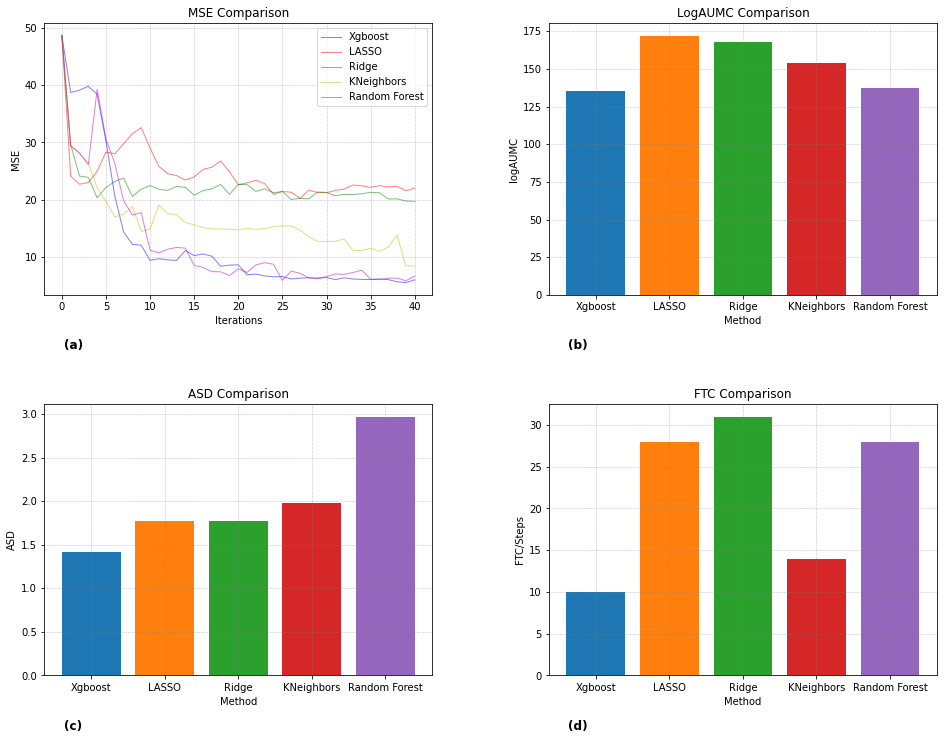

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt

# 创建画布，设置子图大小和间距
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 2, hspace=0.4, wspace=0.3)

# 第1个子图
ax1 = fig.add_subplot(gs[0, 0])
number=np.arange(0,41)
ax1.plot(number, mean_squared_error_list[0:50], 'b-', alpha=0.5, linewidth=1, label='Xgboost')
ax1.plot(number, L1_mean_squared_error_list[0:50], 'r-', alpha=0.5, linewidth=1, label='LASSO')
ax1.plot(number, L2_mean_squared_error_list[0:50], 'g-', alpha=0.5, linewidth=1, label='Ridge')
ax1.plot(number, KN_mean_squared_error_list[0:50], 'y-', alpha=0.5, linewidth=1, label='KNeighbors')
ax1.plot(number, xgb_mean_squared_error_list[0:50], 'm-', alpha=0.5, linewidth=1, label='Random Forest')
ax1.legend()  #显示上面的label
ax1.set_xlabel('Iterations') #x_label
ax1.set_ylabel('MSE')#y_label
ax1.set_title('MSE Comparison')
ax1.text(0.05, -0.2, "(a)", transform=ax1.transAxes, fontweight="bold", fontsize=12)

# 第2个子图
ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(method_reg, logAUC_reg, color=colors)
ax2.set_xlabel('Method')
ax2.set_ylabel('logAUMC')
ax2.set_title('LogAUMC Comparison')
ax2.text(0.05, -0.2, "(b)", transform=ax2.transAxes, fontweight="bold", fontsize=12)

# 第3个子图
ax3 = fig.add_subplot(gs[1, 0])
ax3.bar(method_reg, ASD_reg, color=colors)
ax3.set_xlabel('Method')
ax3.set_ylabel('ASD')
ax3.set_title('ASD Comparison')
ax3.text(0.05, -0.2, "(c)", transform=ax3.transAxes, fontweight="bold", fontsize=12)

# 第4个子图
ax4 = fig.add_subplot(gs[1, 1])
ax4.bar(method_reg, FTC_reg, color=colors)
ax4.set_xlabel('Method')
ax4.set_ylabel('FTC/Steps')
ax4.set_title('FTC Comparison')
ax4.text(0.05, -0.2, "(d)", transform=ax4.transAxes, fontweight="bold", fontsize=12)



# 设置所有子图的网格线
for ax in [ax1, ax2, ax3, ax4]:
    ax.grid(color='gray', linestyle=':', linewidth=0.5)

# 显示所有子图
plt.show()
